# SY 클래스 라벨 의미 검증 및 시각화 EDA
SY(낙상) 클래스 샘플의 영상, 이미지, 센서 시퀀스를 시각화하여 실제 낙상 동작이 맞는지 육안 검증합니다.

## 1. 필요 라이브러리 임포트
데이터 분석 및 시각화를 위한 pandas, numpy, matplotlib, cv2, tqdm, scipy.signal(find_peaks) 등을 임포트합니다.

In [17]:
# 필요 라이브러리 임포트
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from scipy.signal import find_peaks

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. SY 클래스 샘플 목록 추출 및 경로 생성
SY(낙상) 클래스 샘플만 추출하고, 영상/이미지/센서 파일 경로를 생성합니다.

In [22]:
# SY(낙상) / N(비낙상) 샘플 로드 및 센서/비디오 파일 경로 생성
clean_csv_path = 'train_clean.csv'
df_clean = pd.read_csv(clean_csv_path)
print(df_clean['class'].value_counts())

def with_file_paths(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['sensor_path'] = df.apply(lambda r: os.path.join(r['sensor_dir'], f"{r['scene_id']}.csv"), axis=1)
    df['video_path'] = df.apply(lambda r: os.path.join(r['video_dir'], f"{r['scene_id']}.mp4"), axis=1)
    df['image_dir'] = df['image_dir'].astype(str)
    return df

# 기존 변수명(sy_samples)은 유지해서 아래 통계 셀과 호환
sy_samples = with_file_paths(df_clean[df_clean['class'] == 'Y/SY'])
nn_samples = with_file_paths(df_clean[df_clean['class'] == 'N/N'])

print(f"SY(낙상) 샘플 수: {len(sy_samples)}")
print(f"N(비낙상) 샘플 수: {len(nn_samples)}")

sy_samples.head()

class
N/N     2272
Y/SY    1856
Name: count, dtype: int64
SY(낙상) 샘플 수: 1856
N(비낙상) 샘플 수: 2272


,scene_id,class,image_dir,video_dir,sensor_dir,sensor_path,video_path
2272,02091_H_A_SY_C7,Y/SY,../data/train/raw/image/Y/SY/02091_H_A_SY_C7,../data/train/raw/video/Y/SY/02091_H_A_SY_C7,../data/train/raw/sensor/Y/SY/02091_H_A_SY_C7,../data/train/raw/sensor/Y/SY/02091_H_A_SY_C7/...,../data/train/raw/video/Y/SY/02091_H_A_SY_C7/0...
2273,00022_H_A_SY_C8,Y/SY,../data/train/raw/image/Y/SY/00022_H_A_SY_C8,../data/train/raw/video/Y/SY/00022_H_A_SY_C8,../data/train/raw/sensor/Y/SY/00022_H_A_SY_C8,../data/train/raw/sensor/Y/SY/00022_H_A_SY_C8/...,../data/train/raw/video/Y/SY/00022_H_A_SY_C8/0...
2274,02107_H_A_SY_C8,Y/SY,../data/train/raw/image/Y/SY/02107_H_A_SY_C8,../data/train/raw/video/Y/SY/02107_H_A_SY_C8,../data/train/raw/sensor/Y/SY/02107_H_A_SY_C8,../data/train/raw/sensor/Y/SY/02107_H_A_SY_C8/...,../data/train/raw/video/Y/SY/02107_H_A_SY_C8/0...
2275,02211_H_A_SY_C7,Y/SY,../data/train/raw/image/Y/SY/02211_H_A_SY_C7,../data/train/raw/video/Y/SY/02211_H_A_SY_C7,../data/train/raw/sensor/Y/SY/02211_H_A_SY_C7,../data/train/raw/sensor/Y/SY/02211_H_A_SY_C7/...,../data/train/raw/video/Y/SY/02211_H_A_SY_C7/0...
2276,00112_H_A_SY_C1,Y/SY,../data/train/raw/image/Y/SY/00112_H_A_SY_C1,../data/train/raw/video/Y/SY/00112_H_A_SY_C1,../data/train/raw/sensor/Y/SY/00112_H_A_SY_C1,../data/train/raw/sensor/Y/SY/00112_H_A_SY_C1/...,../data/train/raw/video/Y/SY/00112_H_A_SY_C1/0...


## 3. SY 샘플 센서/영상/이미지 시각화
SY 샘플 중 일부를 선택하여 센서 시퀀스, 영상 프레임, 이미지 샘플을 시각화합니다.

          scene_id class                                        sensor_path
0  00162_H_A_SY_C2  Y/SY  ../data/train/raw/sensor/Y/SY/00162_H_A_SY_C2/...
1  02423_H_A_SY_C7  Y/SY  ../data/train/raw/sensor/Y/SY/02423_H_A_SY_C7/...
2   00036_H_A_N_C6   N/N  ../data/train/raw/sensor/N/N/00036_H_A_N_C6/00...
3   02306_H_A_N_C5   N/N  ../data/train/raw/sensor/N/N/02306_H_A_N_C5/02...


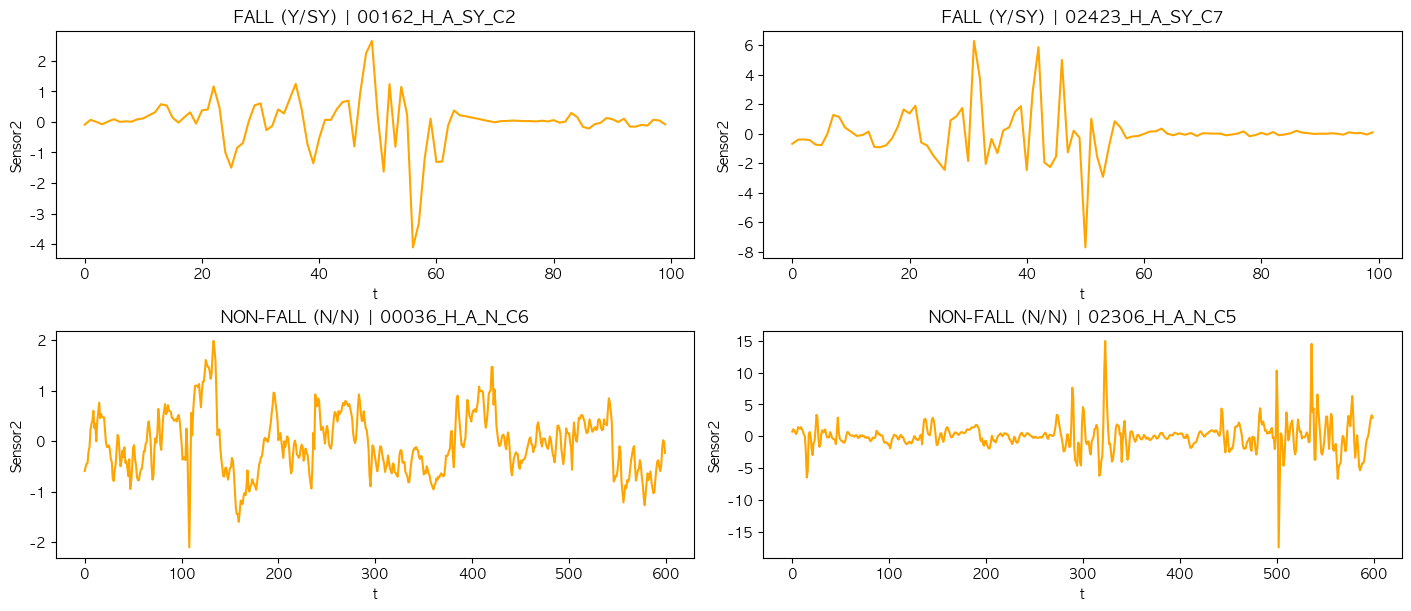

In [23]:
# 낙상 2개 + 비낙상 2개의 Sensor2 시퀀스(센서2) 시각화

def pick_with_existing_sensor(df: pd.DataFrame, n: int, seed: int) -> pd.DataFrame:
    df2 = df.copy()
    df2 = df2[df2['sensor_path'].apply(os.path.exists)]
    if len(df2) >= n:
        return df2.sample(n=n, random_state=seed)
    return df2.head(n)

fall_vis = pick_with_existing_sensor(sy_samples, n=2, seed=42).assign(_label='FALL (Y/SY)')
nonfall_vis = pick_with_existing_sensor(nn_samples, n=2, seed=43).assign(_label='NON-FALL (N/N)')

vis = pd.concat([fall_vis, nonfall_vis], ignore_index=True)
print(vis[['scene_id', 'class', 'sensor_path']])

fig, axes = plt.subplots(2, 2, figsize=(14, 6), constrained_layout=True)
axes = axes.ravel()

for i, (_, row) in enumerate(vis.iterrows()):
    ax = axes[i]
    title = f"{row['_label']} | {row['scene_id']}"
    sensor_path = row['sensor_path']

    if not os.path.exists(sensor_path):
        ax.set_title(title + " (센서 파일 없음)")
        ax.axis('off')
        continue

    df_sensor = pd.read_csv(sensor_path)
    if df_sensor.shape[1] < 2:
        ax.set_title(title + " (Sensor2 컬럼 없음)")
        ax.plot(df_sensor.iloc[:, 0].to_numpy())
    else:
        ax.set_title(title)
        ax.plot(df_sensor.iloc[:, 1].to_numpy(), color='orange')

    ax.set_xlabel('t')
    ax.set_ylabel('Sensor2')

for ax in axes[len(vis):]:
    ax.axis('off')

plt.show()

built X_seq: (1600, 200) y: (1600,)
label counts: {1: 800, 0: 800}

Summary (normalized/resampled):
         non-fall_mean  fall_mean  non-fall_std  fall_std
abs_max       5.651506   4.436666      1.826575  0.968806
energy        0.887728   0.698715      0.163457  0.071524
tv            0.552058   0.269942      0.097554  0.044113


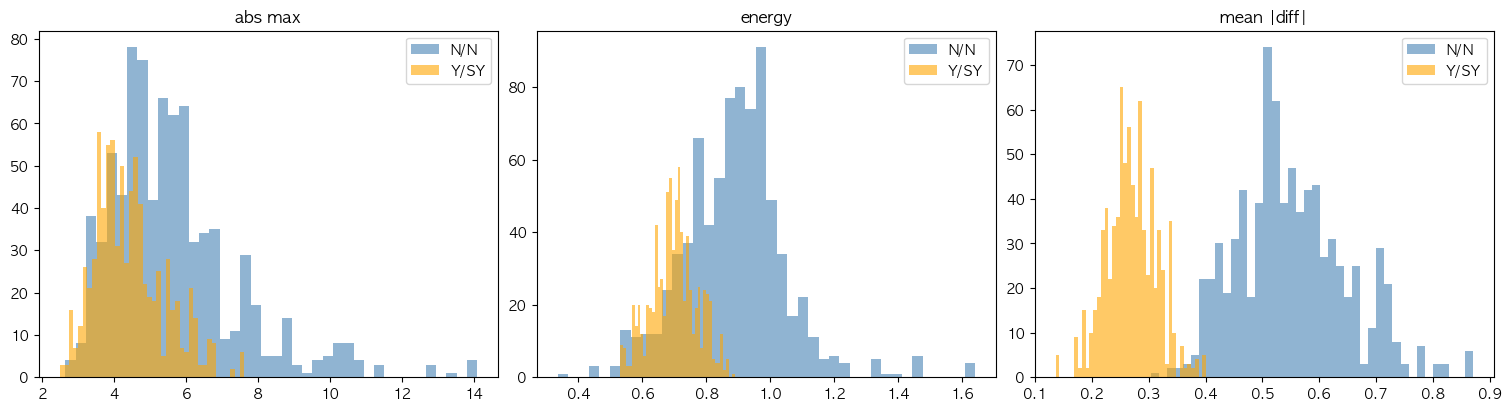

In [25]:
# (분류용) Sensor2 정규화 + 길이 통일 + 간단 통계 비교

from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

@dataclass
class Sensor2Config:
    fixed_len: int = 200
    max_per_class: int = 800  # 클래스별 최대 샘플 수 (속도용)
    seed: int = 42
    eps: float = 1e-6

cfg = Sensor2Config()


def load_sensor2(path: str) -> Optional[np.ndarray]:
    if not os.path.exists(path):
        return None
    try:
        df = pd.read_csv(path)
    except Exception:
        return None
    if df.shape[1] < 2:
        return None
    x = df.iloc[:, 1].to_numpy(dtype=np.float32)
    if x.size < 5:
        return None
    return x


def zscore(x: np.ndarray, eps: float) -> np.ndarray:
    mu = float(np.mean(x))
    sd = float(np.std(x))
    return (x - mu) / (sd + eps)


def resample_1d(x: np.ndarray, fixed_len: int) -> np.ndarray:
    if x.size == fixed_len:
        return x
    xp = np.linspace(0.0, 1.0, num=x.size, dtype=np.float32)
    fp = x.astype(np.float32)
    xnew = np.linspace(0.0, 1.0, num=fixed_len, dtype=np.float32)
    return np.interp(xnew, xp, fp).astype(np.float32)


def build_sensor2_dataset(df_clean: pd.DataFrame, cfg: Sensor2Config) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    # 균형 샘플링
    df_fall = df_clean[df_clean['class'] == 'Y/SY'].copy()
    df_non = df_clean[df_clean['class'] == 'N/N'].copy()

    df_fall = df_fall.sample(n=min(cfg.max_per_class, len(df_fall)), random_state=cfg.seed)
    df_non = df_non.sample(n=min(cfg.max_per_class, len(df_non)), random_state=cfg.seed + 1)

    df_sel = pd.concat([df_fall, df_non], ignore_index=True)
    df_sel = df_sel.sample(frac=1.0, random_state=cfg.seed).reset_index(drop=True)

    X_list: List[np.ndarray] = []
    y_list: List[int] = []
    meta_rows: List[Dict[str, object]] = []

    for _, r in df_sel.iterrows():
        sensor_path = os.path.join(r['sensor_dir'], "%s.csv" % r['scene_id'])
        x = load_sensor2(sensor_path)
        if x is None:
            continue
        x = zscore(x, cfg.eps)
        x = resample_1d(x, cfg.fixed_len)
        label = 1 if r['class'] == 'Y/SY' else 0

        X_list.append(x)
        y_list.append(label)
        meta_rows.append({
            'scene_id': r['scene_id'],
            'class': r['class'],
            'sensor_path': sensor_path,
            'orig_len': int(len(pd.read_csv(sensor_path))),
        })

    if X_list:
        X = np.stack(X_list, axis=0).astype(np.float32)
    else:
        X = np.zeros((0, cfg.fixed_len), dtype=np.float32)
    y = np.array(y_list, dtype=np.int64)
    meta = pd.DataFrame(meta_rows)
    return X, y, meta


X_seq, y, meta = build_sensor2_dataset(df_clean, cfg)
print('built X_seq:', X_seq.shape, 'y:', y.shape)
print('label counts:', pd.Series(y).value_counts().to_dict())

# 간단 통계 비교 (정규화된/resample된 시퀀스 기준)
if X_seq.shape[0] > 0:
    abs_max = np.max(np.abs(X_seq), axis=1)
    energy = np.mean(X_seq ** 2, axis=1)
    tv = np.mean(np.abs(np.diff(X_seq, axis=1)), axis=1)  # total variation (평균 |차분|)

    df_feat = pd.DataFrame({
        'y': y,
        'abs_max': abs_max,
        'energy': energy,
        'tv': tv,
    })

    def summarize(col: str) -> pd.DataFrame:
        g = df_feat.groupby('y')[col]
        return pd.DataFrame({
            'non-fall_mean': [g.mean().get(0, np.nan)],
            'fall_mean': [g.mean().get(1, np.nan)],
            'non-fall_std': [g.std().get(0, np.nan)],
            'fall_std': [g.std().get(1, np.nan)],
        })

    print('\nSummary (normalized/resampled):')
    print(pd.concat([
        summarize('abs_max').rename(index={0: 'abs_max'}),
        summarize('energy').rename(index={0: 'energy'}),
        summarize('tv').rename(index={0: 'tv'}),
    ]))

    # 분포 시각화
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
    for ax, col, title in zip(axes, ['abs_max', 'energy', 'tv'], ['abs max', 'energy', 'mean |diff|']):
        ax.hist(df_feat[df_feat['y'] == 0][col], bins=40, alpha=0.6, label='N/N', color='steelblue')
        ax.hist(df_feat[df_feat['y'] == 1][col], bins=40, alpha=0.6, label='Y/SY', color='orange')
        ax.set_title(title)
        ax.legend()
    plt.show()

CV accuracy: 0.8475000000000001 +/- 0.007756046028744285
CV ROC-AUC : 0.8871953124999999 +/- 0.009069346820902383


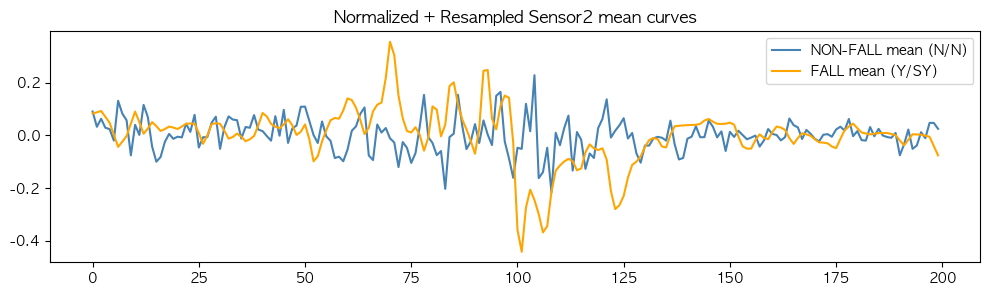

In [26]:
# (분류용) 간단 분류기 베이스라인: Sensor2만으로 어디까지 되나?

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

if X_seq.shape[0] == 0:
    print('X_seq가 비어있어서 학습/평가를 건너뜁니다.')
else:
    X = X_seq  # shape: [N, fixed_len]

    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=2000, class_weight='balanced')),
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.seed)
    scores = cross_validate(
        clf,
        X,
        y,
        cv=cv,
        scoring={'acc': 'accuracy', 'auc': 'roc_auc'},
        n_jobs=-1,
        return_train_score=False,
    )

    print('CV accuracy:', float(np.mean(scores['test_acc'])), '+/-', float(np.std(scores['test_acc'])))
    print('CV ROC-AUC :', float(np.mean(scores['test_auc'])), '+/-', float(np.std(scores['test_auc'])))

    # 학습된 모델이 아니라서(교차검증) 해석용으로 평균 시퀀스만 비교
    fall_mean = X[y == 1].mean(axis=0)
    non_mean = X[y == 0].mean(axis=0)

    plt.figure(figsize=(12, 3))
    plt.plot(non_mean, label='NON-FALL mean (N/N)', color='steelblue')
    plt.plot(fall_mean, label='FALL mean (Y/SY)', color='orange')
    plt.title('Normalized + Resampled Sensor2 mean curves')
    plt.legend()
    plt.show()

## 3-1. 골반 가속도(near-fall vs fall) 패턴 시각화
- 정상(N/N): 순간 spike 이후 빠르게 안정화(near-fall-like)
- 낙상(Y/SY): 이벤트 이후 약 2초 구간에서 변동이 지속

아래 셀은 위 패턴이 잘 보이는 샘플을 자동으로 골라, 이벤트(최대 가속도) 시점을 0초로 정렬해 그림을 저장합니다.

PPT pick (Normal near-fall-like): 01999_H_A_N_C3
PPT pick (Fall): 00531_H_D_SY_C8


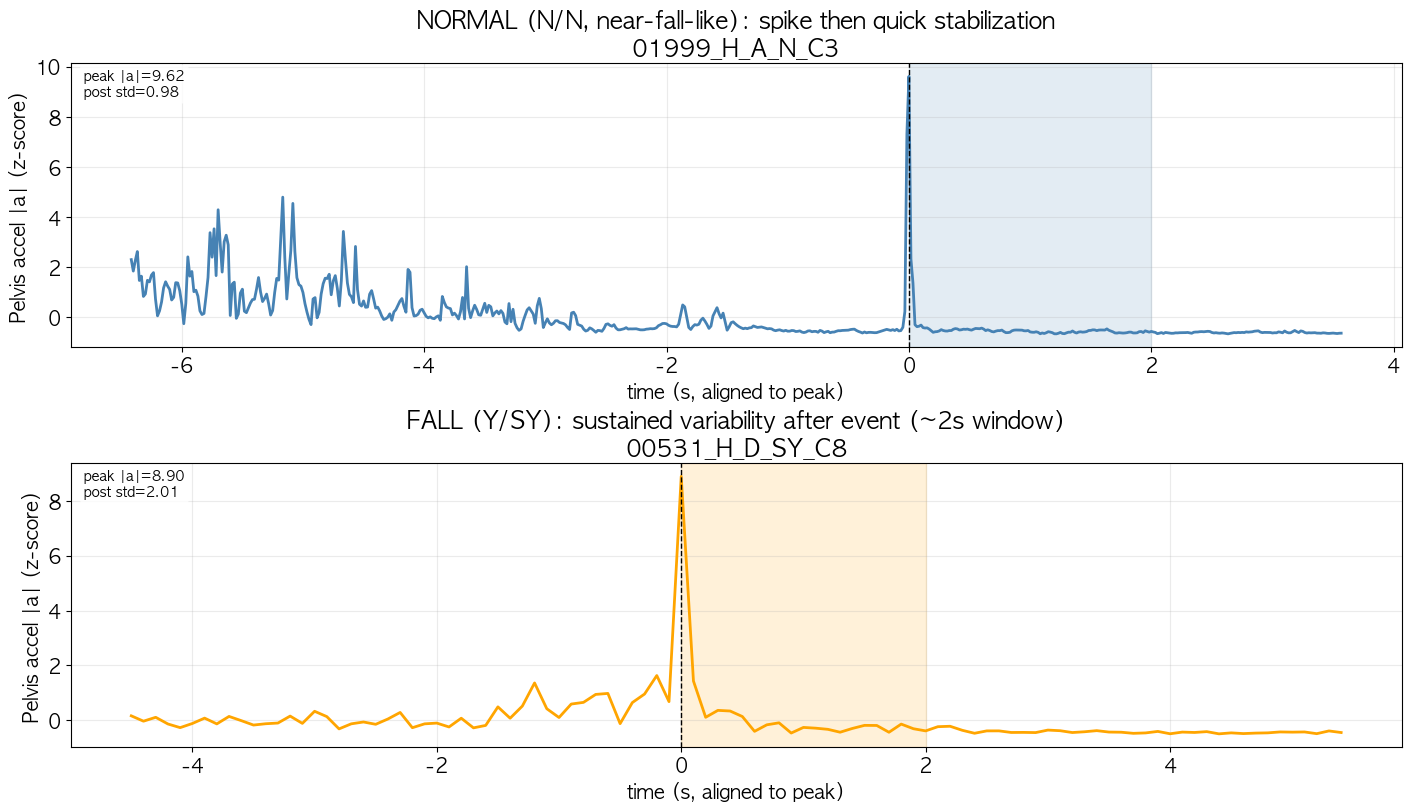

Saved PPT figure: exports/pelvis_acc_nearfall_vs_fall.png


In [27]:
# PPT용: 골반 가속도 magnitude(√(x^2+y^2+z^2)) 시각화 + 자동 샘플 선택 + PNG 저장

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FPS_ASSUMED = 60.0      # 'Frame' 컬럼이 프레임 번호일 때, 초 단위로 변환하기 위한 가정
POST_SEC = 2.0          # 강조할 "낙상 후 2초" 구간
MAX_SCAN_PER_CLASS = 400  # 자동 샘플 선택 속도용 (클래스별 최대 스캔 수)
SEED = 42
OUT_DIR = os.path.join('exports')
OUT_PATH = os.path.join(OUT_DIR, 'pelvis_acc_nearfall_vs_fall.png')


def load_pelvis_acc_mag(sensor_path: str):
    if not os.path.exists(sensor_path):
        return None
    try:
        df = pd.read_csv(sensor_path)
    except Exception:
        return None

    cols = [
        'Segment Acceleration_Pelvis x',
        'Segment Acceleration_Pelvis y',
        'Segment Acceleration_Pelvis z',
    ]
    if not all(c in df.columns for c in cols):
        return None

    ax = df[cols[0]].to_numpy(dtype=np.float32)
    ay = df[cols[1]].to_numpy(dtype=np.float32)
    az = df[cols[2]].to_numpy(dtype=np.float32)
    mag = np.sqrt(ax * ax + ay * ay + az * az)

    if 'Frame' in df.columns:
        frame = pd.to_numeric(df['Frame'], errors='coerce').to_numpy(dtype=np.float32)
        if np.isfinite(frame).all() and len(frame) == len(mag):
            t = frame / FPS_ASSUMED
        else:
            t = np.arange(len(mag), dtype=np.float32)
    else:
        t = np.arange(len(mag), dtype=np.float32)

    if len(mag) < 10:
        return None

    # z-score (PPT에서 스케일 비교 용이)
    mu = float(np.mean(mag))
    sd = float(np.std(mag))
    mag_z = (mag - mu) / (sd + 1e-6)

    return t, mag_z


def score_sequence(t: np.ndarray, x: np.ndarray, post_sec: float):
    # 이벤트: |x| 최대 지점
    peak_i = int(np.argmax(np.abs(x)))

    # dt 추정
    if len(t) >= 3:
        dt = float(np.median(np.diff(t)))
        if not np.isfinite(dt) or dt <= 0:
            dt = 1.0
    else:
        dt = 1.0

    post_win = max(3, int(round(post_sec / dt)))
    post_end = min(len(x), peak_i + post_win)
    pre_start = max(0, peak_i - post_win)

    post_std = float(np.std(x[peak_i:post_end]))
    pre_std = float(np.std(x[pre_start:peak_i])) if peak_i - pre_start >= 3 else float(np.std(x[:max(3, peak_i)]))
    peak_abs = float(np.max(np.abs(x)))

    # "낙상 후 변동 지속"을 반영: post_std가 크면 점수↑
    # "near-fall"을 반영: peak는 크지만 post_std는 작으면 점수↑
    return {
        'peak_i': peak_i,
        'dt': dt,
        'post_win': post_win,
        'peak_abs': peak_abs,
        'post_std': post_std,
        'pre_std': pre_std,
    }


def build_candidates(df: pd.DataFrame, class_name: str, max_n: int, seed: int):
    dfc = df[df['class'] == class_name].copy()
    dfc = dfc.sample(n=min(max_n, len(dfc)), random_state=seed)

    rows = []
    for _, r in dfc.iterrows():
        sensor_path = os.path.join(r['sensor_dir'], "%s.csv" % r['scene_id'])
        loaded = load_pelvis_acc_mag(sensor_path)
        if loaded is None:
            continue
        t, x = loaded
        s = score_sequence(t, x, POST_SEC)
        rows.append({
            'scene_id': r['scene_id'],
            'class': r['class'],
            'sensor_path': sensor_path,
            't': t,
            'x': x,
            **s,
        })
    return rows


# 후보 생성
fall_rows = build_candidates(df_clean, 'Y/SY', MAX_SCAN_PER_CLASS, SEED)
non_rows = build_candidates(df_clean, 'N/N', MAX_SCAN_PER_CLASS, SEED + 1)

if not fall_rows or not non_rows:
    print('후보 샘플을 충분히 만들지 못했습니다. (센서 파일/컬럼 확인 필요)')
else:
    non_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ('t', 'x')} for r in non_rows])
    fall_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ('t', 'x')} for r in fall_rows])

    # Normal near-fall-like: peak_abs는 큰 편(상위 25%), post_std는 작은 편(하위 25%)
    peak_thr = float(non_df['peak_abs'].quantile(0.75))
    post_thr = float(non_df['post_std'].quantile(0.25))

    non_nf = non_df[(non_df['peak_abs'] >= peak_thr) & (non_df['post_std'] <= post_thr)].copy()
    if len(non_nf) == 0:
        # 조건이 너무 빡세면 "peak_abs - post_std" 최대인 샘플로 대체
        non_nf = non_df.copy()
        non_nf['score_nf'] = non_nf['peak_abs'] - non_nf['post_std']
        non_pick_id = non_nf.sort_values('score_nf', ascending=False).iloc[0]['scene_id']
    else:
        non_nf['score_nf'] = non_nf['peak_abs'] - non_nf['post_std']
        non_pick_id = non_nf.sort_values('score_nf', ascending=False).iloc[0]['scene_id']

    # Fall: post_std 상위 1개 (변동 지속이 큰 샘플)
    fall_pick_id = fall_df.sort_values('post_std', ascending=False).iloc[0]['scene_id']

    def find_row(rows, scene_id):
        for r in rows:
            if r['scene_id'] == scene_id:
                return r
        return None

    non_pick = find_row(non_rows, non_pick_id)
    fall_pick = find_row(fall_rows, fall_pick_id)

    print('PPT pick (Normal near-fall-like):', non_pick_id)
    print('PPT pick (Fall):', fall_pick_id)

    # 이벤트 기준 정렬 플롯
    def plot_aligned(ax, r, title, color):
        t = r['t']
        x = r['x']
        peak_i = r['peak_i']
        dt = r['dt']
        post_win = r['post_win']

        t0 = float(t[peak_i])
        tt = t - t0

        ax.plot(tt, x, color=color, linewidth=2)
        ax.axvline(0.0, color='black', linestyle='--', linewidth=1)

        # 0~POST_SEC 강조(가정 기반)
        ax.axvspan(0.0, POST_SEC, color=color, alpha=0.15, label=f'0~{POST_SEC:.0f}s')

        ax.set_title(title)
        ax.set_xlabel('time (s, aligned to peak)')
        ax.set_ylabel('Pelvis accel |a| (z-score)')
        ax.grid(True, alpha=0.25)

        # 설명 텍스트
        ax.text(
            0.01,
            0.98,
            f"peak |a|={r['peak_abs']:.2f}\npost std={r['post_std']:.2f}",
            transform=ax.transAxes,
            va='top',
            ha='left',
            fontsize=10,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none'),
        )

    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), constrained_layout=True)

    plot_aligned(
        axes[0],
        non_pick,
        f"NORMAL (N/N, near-fall-like): spike then quick stabilization\n{non_pick['scene_id']}",
        color='steelblue',
    )
    plot_aligned(
        axes[1],
        fall_pick,
        f"FALL (Y/SY): sustained variability after event (~{POST_SEC:.0f}s window)\n{fall_pick['scene_id']}",
        color='orange',
    )

    os.makedirs(OUT_DIR, exist_ok=True)
    fig.savefig(OUT_PATH, dpi=300, bbox_inches='tight')
    plt.show()

    print('Saved PPT figure:', OUT_PATH)

## 4. SY 샘플 전체 통계 및 품질 분석
SY 샘플의 센서 길이, 영상 프레임 수, 이미지 개수 등 분포와 품질을 요약합니다.

In [13]:
from tqdm import tqdm
import numpy as np
import glob

sensor_lengths = []
video_lengths = []
image_counts = []

for idx, row in tqdm(sy_samples.iterrows(), total=len(sy_samples)):
    # 센서 길이
    if os.path.exists(row['sensor_path']):
        try:
            df_sensor = pd.read_csv(row['sensor_path'])
            sensor_lengths.append(len(df_sensor))
        except Exception as e:
            print(f"센서 파일 읽기 실패: {row['sensor_path']} - {e}")
            sensor_lengths.append(np.nan)
    else:
        print(f"센서 파일 없음: {row['sensor_path']}")
        sensor_lengths.append(np.nan)
    # 영상 프레임 수
    if os.path.exists(row['video_path']):
        try:
            cap = cv2.VideoCapture(row['video_path'])
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            video_lengths.append(frame_count)
            cap.release()
        except Exception as e:
            print(f"영상 파일 읽기 실패: {row['video_path']} - {e}")
            video_lengths.append(np.nan)
    else:
        print(f"영상 파일 없음: {row['video_path']}")
        video_lengths.append(np.nan)
    # 이미지 개수 (하위폴더 포함, 다양한 확장자)
    if os.path.exists(row['image_dir']):
        try:
            patterns = ['**/*.jpg', '**/*.JPG']
            img_files = []
            for pat in patterns:
                img_files += glob.glob(os.path.join(row['image_dir'], pat), recursive=True)
            image_counts.append(len(img_files))
        except Exception as e:
            print(f"이미지 폴더 읽기 실패: {row['image_dir']} - {e}")
            image_counts.append(np.nan)
    else:
        print(f"이미지 폴더 없음: {row['image_dir']}")
        image_counts.append(np.nan)

sy_samples['sensor_length'] = sensor_lengths
sy_samples['video_length'] = video_lengths
sy_samples['image_count'] = image_counts

print('센서 길이 분포:')
print(sy_samples['sensor_length'].describe())
print('영상 프레임 수 분포:')
print(sy_samples['video_length'].describe())
print('이미지 개수 분포:')
print(sy_samples['image_count'].describe())

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(sy_samples['sensor_length'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('센서 길이')
plt.subplot(1,3,2)
plt.hist(sy_samples['video_length'].dropna(), bins=30, color='salmon', edgecolor='black')
plt.title('영상 프레임 수')
plt.subplot(1,3,3)
plt.hist(sy_samples['image_count'].dropna(), bins=30, color='lime', edgecolor='black')
plt.title('이미지 개수')
plt.tight_layout()
plt.show()


 45%|████▍     | 828/1856 [00:06<00:07, 133.39it/s]



KeyboardInterrupt: 

In [ ]:
# 센서 csv를 600 → 100 rows로 다운샘플링 (6개씩 평균)
import pandas as pd
import glob

# 예시: SY 센서 경로 리스트 (필요시 전체 경로로 확장)
sensor_csvs = sy_samples['sensor_path'].tolist()

for csv_path in sensor_csvs:
    if not os.path.exists(csv_path):
        print(f"[경고] 파일 없음: {csv_path}")
        continue
    try:
        df = pd.read_csv(csv_path)
        # 6개씩 평균내서 100개로 다운샘플링
        df_down = df.groupby(df.index // 6).mean()
        df_down = df_down.reset_index(drop=True)
        df_down.to_csv(csv_path, index=False)
        print(f"다운샘플링 완료: {csv_path} → {len(df)} → {len(df_down)} rows")
    except Exception as e:
        print(f"[에러] {csv_path}: {e}")

다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02091_H_A_SY_C7/02091_H_A_SY_C7.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/00022_H_A_SY_C8/00022_H_A_SY_C8.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02107_H_A_SY_C8/02107_H_A_SY_C8.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02211_H_A_SY_C7/02211_H_A_SY_C7.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/00112_H_A_SY_C1/00112_H_A_SY_C1.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02922_H_B_SY_C5/02922_H_B_SY_C5.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02131_H_A_SY_C2/02131_H_A_SY_C2.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02264_H_A_SY_C3/02264_H_A_SY_C3.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/00190_H_A_SY_C8/00190_H_A_SY_C8.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/00645_H_D_SY_C2/00645_H_D_SY_C2.csv → 600 → 100 rows
다운샘플링 완료: ../data/train/raw/sensor/Y/SY/02637_H_A_SY_C1/02637_H_A_SY_C